In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =1e-24

nband = 120

ng =3

ng_refs = (/ 3 /) 

nref =1

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

tsfc =294

vstar = 980

data w_diffuse
     &     /1.66 , 1.66 , 1.8/

data wgt
     &     /0.5 , 0.55 , 0.9/

atmosphere_profiles/mls75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

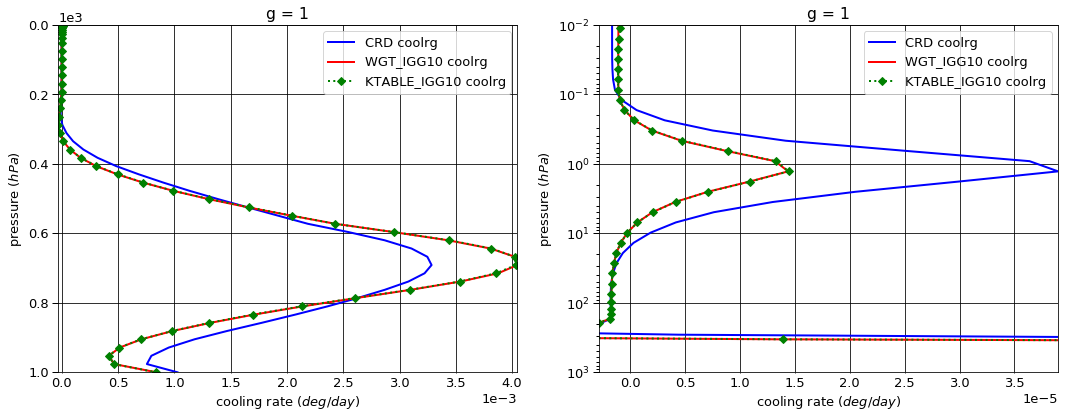

# Figure: cooling rate g-group 2

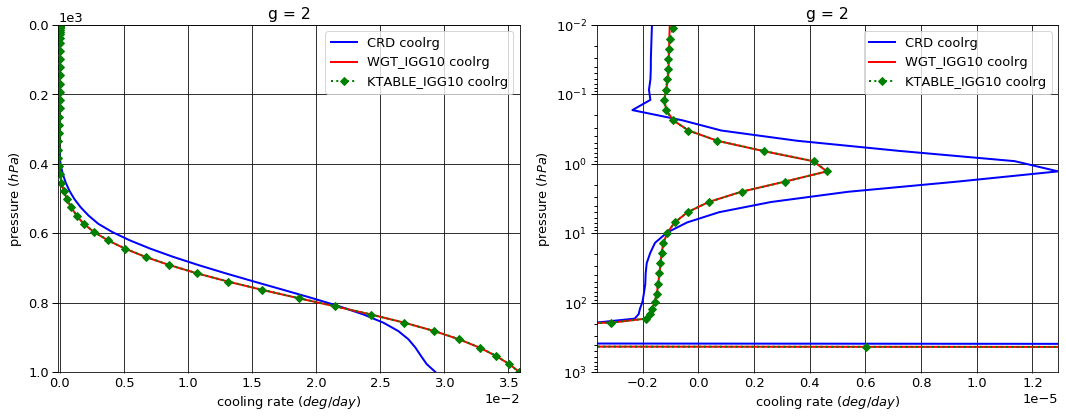

# Figure: cooling rate g-group 3

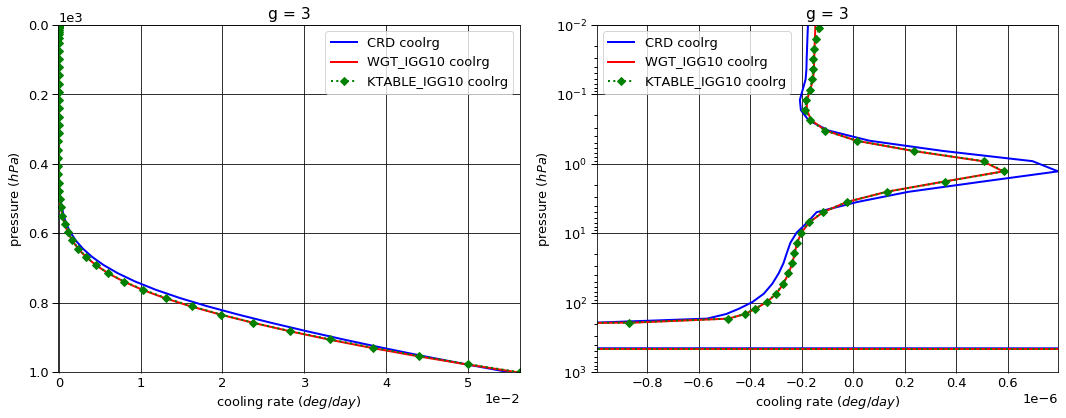

# Figure: cooling rate g-group total

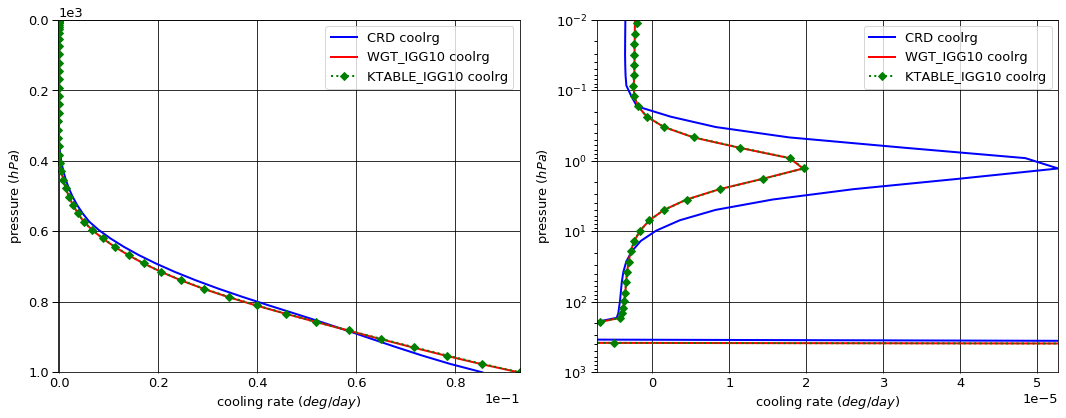

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.146975  0.000000  -0.146975
  1013.0   76     -0.225920  0.220303  -0.005617
2 0.0      1      -1.807086  0.000000  -1.807086
  1013.0   76     -2.029407  1.204134  -0.825273
3 0.0      1     -28.950059  0.000000 -28.950059
  1013.0   76    -29.098910  1.219810 -27.879100


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.145610  0.000000  -0.145610
  1013.0   76     -0.225920  0.222668  -0.003252
2 0.0      1      -1.834158  0.000000  -1.834158
  1013.0   76     -2.029407  1.208552  -0.820855
3 0.0      1     -28.968010  0.000000 -28.968010
  1013.0   76    -29.098910  1.141708 -27.957202


KTABLE_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.145471  0.000000  -0.145471
  1013.0   76     -0.225920  0.222675  -0.003244
2 0.0      1      -1.833582  0.000000  -1.833582
  1013.0   76     -2.029407  1.210161  -0.819246
3 0.0      1     -28.966832  0.000000 -28.966832
  1013.0   76    -29.098910  1.150551 -27.948359


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      1.364380e-03  0.000000  0.001364
  1013.0   76     0.000000e+00  0.002365  0.002365
2 0.0      1     -2.707110e-02  0.000000 -0.027071
  1013.0   76     0.000000e+00  0.004419  0.004419
3 0.0      1     -1.795100e-02  0.000000 -0.017951
  1013.0   76    -3.552714e-15 -0.078102 -0.078102


KTABLE_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      1.503290e-03  0.000000  0.001503
  1013.0   76     0.000000e+00  0.002373  0.002373
2 0.0      1     -2.649550e-02  0.000000 -0.026496
  1013.0   76     0.000000e+00  0.006027  0.006027
3 0.0      1     -1.677300e-02  0.000000 -0.016773
  1013.0   76    -3.552714e-15 -0.069259 -0.069259

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.618411e-06
  1001.112500 75     1.027624e-03
2 0.000312    1     -1.556046e-06
  1001.112500 75     2.932333e-02
3 0.000312    1     -1.634550e-07
  1001.112500 75     5.512247e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.018400e-06
  1001.112500 75     8.411835e-04
2 0.000312    1     -9.451886e-07
  1001.112500 75     3.588694e-02
3 0.000312    1     -1.351157e-07
  1001.112500 75     5.607488e-02


KTABLE_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -5.219767e-07
  1001.112500 75     8.392457e-04
2 0.000312    1     -5.507569e-07
  1001.112500 75     3.585126e-02
3 0.000312    1     -8.756344e-08
  1001.112500 75     5.636420e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      6.000109e-07
  1001.112500 75    -1.864406e-04
2 0.000312    1      6.108577e-07
  1001.112500 75     6.563608e-03
3 0.000312    1      2.833924e-08
  1001.112500 75     9.524080e-04


KTABLE_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.096434e-06
  1001.112500 75    -1.883784e-04
2 0.000312    1      1.005289e-06
  1001.112500 75     6.527922e-03
3 0.000312    1      7.589152e-08
  1001.112500 75     1.241730e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.904120,0.000000,-30.90412
1013.0,76,-31.354237,2.644247,-28.70999



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.947778,0.000000,-30.947778
1013.0,76,-31.354237,2.572928,-28.781309



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.945885,0.000000,-30.945885
1013.0,76,-31.354237,2.583388,-28.770849



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.365772e-02,0.000000,-0.043658
1013.0,76,-3.552714e-15,-0.071319,-0.071318



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.176521e-02,0.000000,-0.041765
1013.0,76,-3.552714e-15,-0.060859,-0.060859


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000003
1001.112500,75,0.085473



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000002
1001.112500,75,0.092803



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000001
1001.112500,75,0.093055



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000001
1001.112500,75,0.007330



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000002
1001.112500,75,0.007581


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.007583,0.007049
2,0.065917,0.064206
3,0.926500,0.928744


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.350702e-23
2,1.000478e-24
3,1.361273e-27


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.350702e-23,NaN,0.007583,0.007049,0.007583,0.007049,600.0
2,1.000478e-24,0.074071,0.065917,0.064206,0.073500,0.071256,600.0
3,1.361273e-27,0.001361,0.926500,0.928744,1.000000,1.000000,600.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog       ratio        taulyr
layer g pressure                                                         
1     1 0.000312     1.088476e-23  1.034125e-24   10.525576  5.075132e-10
      2 0.000312     6.635144e-25  2.565960e-26   25.858333  3.206145e-11
      3 0.000312     3.392888e-27  2.034427e-29  166.773620  2.602212e-13
2     1 0.000750     1.099459e-23  1.035802e-24   10.614563  2.063319e-10
      2 0.000750     6.692775e-25  2.571590e-26   26.025821  1.302352e-11
      3 0.000750     3.418746e-27  2.044365e-29  167.227770  1.056123e-13
3     1 0.001052     1.123073e-23  1.039183e-24   10.807271  2.951178e-10
      2 0.001052     6.816627e-25  2.582702e-26   26.393387  1.859408e-11
      3 0.001052     3.474320e-27  2.060438e-29  168.620450  1.505159e-13
4     1 0.001476     1.148554e-23  1.042691e-24   11.015285  4.227349e-10
      2 0.001476     6.950031e-25  2.594577e-26   26.786761  2.658425e-11
      3 0.001476     3.534241e-27  2.078517e-29  170.036690  2.147982e-13
5     1 0.002070     1.174566e-23  1.046147e-24   11.227536  6.053964e-10
      2 0.002070     7.085952e-25  2.606662e-26   27.184009  3.799946e-11
      3 0.002070     3.595365e-27  2.098334e-29  171.343800  3.064821e-13
6     1 0.002904     1.201095e-23  1.049566e-24   11.443728  8.670514e-10
      2 0.002904     7.224306e-25  2.619057e-26   27.583619  5.432103e-11
      3 0.002904     3.657669e-27  2.120544e-29  172.487300  4.373621e-13
7     1 0.004074     1.228153e-23  1.052974e-24   11.663664  1.241792e-09
      2 0.004074     7.365133e-25  2.631918e-26   27.983901  7.765350e-11
      3 0.004074     3.721184e-27  2.146120e-29  173.391220  6.241716e-13
8     1 0.005714     1.255754e-23  1.056407e-24   11.887030  1.778340e-09
      2 0.005714     7.508472e-25  2.645469e-26   28.382390  1.109986e-10
      3 0.005714     3.785948e-27  2.176435e-29  173.951830  8.907488e-13
9     1 0.008015     1.283918e-23  1.059917e-24   12.113384  2.546752e-09
      2 0.008015     7.654391e-25  2.660028e-26   28.775607  1.586644e-10
      3 0.008015     3.852015e-27  2.213412e-29  174.030640  1.271270e-12
10    1 0.011243     1.312659e-23  1.063575e-24   12.341951  3.647124e-09
      2 0.011243     7.802903e-25  2.676042e-26   29.158371  2.267935e-10
      3 0.011243     3.919421e-27  2.259728e-29  173.446600  1.814411e-12
11    1 0.015771     1.341994e-23  1.067481e-24   12.571599  5.223053e-09
      2 0.015771     7.954022e-25  2.694148e-26   29.523336  3.241788e-10
      3 0.015771     3.988212e-27  2.319087e-29  171.973330  2.589790e-12
12    1 0.022122     1.371965e-23  1.071779e-24   12.800820  7.480161e-09
      2 0.022122     8.107846e-25  2.715249e-26   29.860412  4.633814e-10
      3 0.022122     4.058484e-27  2.396591e-29  169.344040  3.696766e-12
13    1 0.031031     1.402627e-23  1.076672e-24   13.027436  1.071350e-08
      2 0.031031     8.264506e-25  2.740626e-26   30.155538  6.623774e-10
      3 0.031031     4.130368e-27  2.499191e-29  165.268180  5.277433e-12
14    1 0.043528     1.436058e-23  1.082619e-24   13.264670  1.536646e-08
      2 0.043528     8.434474e-25  2.772821e-26   30.418387  9.480134e-10
      3 0.043528     4.208746e-27  2.637711e-29  159.560540  7.543348e-12
15    1 0.061057     1.537655e-23  1.095331e-24   14.038265  2.299059e-08
      2 0.061057     8.952950e-25  2.838298e-26   31.543375  1.410221e-09
      3 0.061057     4.447646e-27  2.875563e-29  154.670430  1.118205e-11
16    1 0.085645     1.839499e-23  1.122673e-24   16.384991  3.821207e-08
      2 0.085645     1.048645e-24  2.983179e-26   35.151939  2.310929e-09
      3 0.085645     5.163384e-27  3.357407e-29  153.790800  1.820930e-11
17    1 0.120136     2.353674e-23  1.161240e-24   20.268624  6.782697e-08
      2 0.120136     1.307180e-24  3.207281e-26   40.756651  4.028109e-09
      3 0.120136     6.412345e-27  4.180178e-29  153.398870  3.172085e-11
18    1 0.168516     3.006526e-23  1.210388e-24   24.839355  1.204811e-07
      2 0.168516     1.632313e

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
